<a href="https://colab.research.google.com/github/pongsapaks/Detection-depression/blob/main/BERT_detecting_depression_with_up_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-56fafa23-a979-859f-f77b-a3eb24bf1fa6)


In [18]:
!pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.9 MB/s eta 0:00:00


In [19]:
#importing the libraries
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
import os
import re
import glob

import numpy as np
import pandas as pd
import chart_studio.plotly as py
import plotly.graph_objs as go
import itertools
from scipy import stats
from ast import literal_eval
#import spacy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score,classification_report,  ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score,classification_report,  ConfusionMatrixDisplay, confusion_matrix


In [20]:
import gensim
import json
import pickle

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model   #from keras.utils.vis_utils import plot_model
import keras.utils
from keras import utils as np_utils

#Keras Tokenizer just replaces certain punctuation characters and splits on the remaining space character.
#NLTK Tokenizer uses the Treebank tokenizer uses regular expressions to tokenize text as in Penn Treebank.

In [21]:
WINDOWS_SIZE = 10
labels=['no','yes']
num_classes = len(labels)

In [39]:
#converting the transcript files into a dataframe
def transcripts_to_dataframe(directory):
    rows_list = []
    folders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    folders = sorted(folders)
    for folder in folders:
      folder_path = os.path.join(directory, folder)
      filenames = [f for f in os.listdir(folder_path) if f.lower().endswith('.csv')]

      if ".DS_Store" in filenames:
        filenames.remove(".DS_Store")

      for filename in filenames:
        transcript_path = os.path.join(folder_path, filename)
        transcript = pd.read_csv(transcript_path,encoding='utf-8', sep='\t')
        m = re.search("(\d{3})_TRANSCRIPT.csv", filename)
        if m:
            person_id = m.group(1)
            p = {}
            question = ""
            answer = ""
            lines = len(transcript)
            for i in range(0, lines):
                row = transcript.iloc[i]
                if (row["speaker"] == "Ellie") or (i == lines - 1):
                    p["personId"] = person_id
                    if "(" in str(question):
                        question = question[question.index("(") + 1:question.index(")")]
                    p["question"] = question
                    p["answer"] = answer
                    if question != "":
                        rows_list.append(p)
                    p = {}
                    answer = ""
                    question = row["value"]
                else:
                    answer = str(answer) + " " + str(row["value"])

    all_participants = pd.DataFrame(rows_list, columns=['personId', 'question', 'answer'])
    #all_participants = all_participants.sort_values(by= 'personId').reset_index(drop=True)
    #all_participants.to_csv("/content/drive/MyDrive/Final_DLP/" + 'all.csv', sep=',', index=False)
    print("File was created")
    return all_participants

In [ ]:
data_path = "/content/drive/MyDrive/Final_DLP/data/"
all_participants = transcripts_to_dataframe(data_path)

In [22]:
 all_participants = pd.read_csv("/content/drive/MyDrive/Final_DLP/all.csv")
 all_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14903 entries, 0 to 14902
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   personId  14903 non-null  int64 
 1   question  14902 non-null  object
 2   answer    10468 non-null  object
dtypes: int64(1), object(2)
memory usage: 349.4+ KB


In [23]:
display(all_participants)

,personId,question,answer
0,300,hi i'm ellie thanks for coming in today,NaN
1,300,i was created to talk to people in a safe and ...,NaN
2,300,think of me as a friend i don't judge i can't ...,NaN
3,300,i'm here to learn about people and would love ...,NaN
4,300,i'll ask a few questions to get us started and...,NaN
...,...,...,...
14898,492,mm,NaN
14899,492,what are you most proud of in your life,um i am very proud of the fact that uh i don'...
14900,492,okay i think i have asked everything i need to,NaN
14901,492,thanks for sharing your thoughts with me,NaN


In [24]:
#Selecting the data from the data from based on the questions asked  ['where', 'when', 'how', 'why', 'are', 'what', 'do', 'have', 'can', 'did', 'is', 'could', 'so', 'tell', 'who', 'has']
interrogative = ["where", "when", "how","why","are","what","do","have","can","did","is", "could", "so", "tell", "who", "has"]
rslt_df = all_participants[all_participants.question.str.contains('|'.join(interrogative),na=False)]
rslt_df['answer'].replace('', np.nan, inplace=True)
rslt_df.dropna(subset = ["answer"], inplace=True)
rslt_df.reset_index(drop=True, inplace=True)
rslt_df
#rslt_df = rslt_df.to_csv("/content/drive/MyDrive/Final_DLP/rslt_df.csv" , index=False)

<ipython-input-24-8ecdc889ece2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rslt_df['answer'].replace('', np.nan, inplace=True)
<ipython-input-24-8ecdc889ece2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rslt_df.dropna(subset = ["answer"], inplace=True)


,personId,question,answer
0,300,how are you doing today,good
1,300,where are you from originally,atlanta georgia
2,300,why'd you move to l_a,um my parents are from here um
3,300,how do you like l_a,i love it
4,300,what are some things you really like about l_a,i like the weather i like the opportunities u...
...,...,...,...
8661,492,how would your best friend describe you,that uh i'm smart they would say that i'm sma...
8662,492,what are some things you wish you could change...,um i don't wanna change anything i do want to...
8663,492,is there anything you regret,no
8664,492,what advice would you give to yourself ten or ...,mm that's a good question i would have uh i w...


In [25]:
rslt_df = pd.read_csv("/content/drive/MyDrive/Final_DLP/rslt_df.csv")
rslt_df['question']= rslt_df.apply(lambda row: "{0}?".format(row.question), axis=1)
rslt_df

,personId,question,answer
0,300,how are you doing today?,good
1,300,where are you from originally?,atlanta georgia
2,300,why'd you move to l_a?,um my parents are from here um
3,300,how do you like l_a?,i love it
4,300,what are some things you really like about l_a?,i like the weather i like the opportunities u...
...,...,...,...
8661,492,how would your best friend describe you?,that uh i'm smart they would say that i'm sma...
8662,492,what are some things you wish you could change...,um i don't wanna change anything i do want to...
8663,492,is there anything you regret?,no
8664,492,what advice would you give to yourself ten or ...,mm that's a good question i would have uh i w...


In [26]:
rslt_df_concat = rslt_df.groupby('personId').agg({'answer': ' '.join}).reset_index()
rslt_df_concat

,personId,answer
0,300,good atlanta georgia um my parents are from...
1,301,mmm k i'm doing good thank you i'm from los...
2,302,i'm fine how about yourself i'm from los an...
3,303,okay how 'bout yourself here in california ...
4,304,i'm doing good um from los angeles californi...
...,...,...
180,488,yes fine oh san fernando valley uh well i ...
181,489,yes i'm doing well thank you san luis obisp...
182,490,yeah i'm doing already how are you doing no...
183,491,yes huh overwhelmed i have a funeral to att...


In [27]:
def load_avec_dataset_file(path,score_column):
    ds = pd.read_csv(path, sep=',')
    ds['level'] = pd.cut(ds[score_column], bins=[-1,9,25], labels=[0,1])  #cut function used to segregate array into bins 2 levels - 'no','yes' using a PHQ score greater than or equal 10.
    ds['cat_level'] = keras.utils.to_categorical(ds['level'], num_classes).tolist() #categorical levels
    ds['PHQ8_Score'] = ds[score_column]
    ds = ds[['Participant_ID', 'level', 'cat_level', 'PHQ8_Score']]
    ds = ds.astype({"Participant_ID": int, "level": int, 'PHQ8_Score': int})
    return ds

In [28]:
train = load_avec_dataset_file('/content/drive/MyDrive/Final_DLP/data/Label/train_split_Depression_AVEC2017.csv','PHQ8_Score')
dev = load_avec_dataset_file('/content/drive/MyDrive/Final_DLP/data/Label/dev_split_Depression_AVEC2017.csv','PHQ8_Score')
test = load_avec_dataset_file('/content/drive/MyDrive/Final_DLP/data/Label/full_test_split.csv','PHQ_Score')
print("Size: train= {}, dev= {}, test= {}".format(len(train), len(dev), len(test)))

Size: train= 107, dev= 35, test= 47


In [29]:
train_lp = train.merge(rslt_df, left_on = train.Participant_ID.astype(int), right_on=rslt_df.personId.astype(int))
test_lp = test.merge(rslt_df_concat, left_on = test.Participant_ID.astype(int), right_on=rslt_df_concat.personId.astype(int))
dev_lp = dev.merge(rslt_df,left_on=dev.Participant_ID.astype(int).astype(int), right_on=rslt_df.personId.astype(int))


Upsampling for train dataset

In [30]:
df_neg = train_lp[train_lp.level == 0]
df_pos = train_lp[train_lp.level == 1]

ori_neg_ids = df_neg.Participant_ID.values
ori_pos_ids = df_pos.Participant_ID.values

print(f"No of non-depressed: {len(ori_neg_ids)}. No of depressed: {len(ori_pos_ids)}")

No of non-depressed: 3540. No of depressed: 1503


In [31]:
df_pos_concat  = df_pos.groupby('personId').agg({'answer': ' '.join}).reset_index()
rslt_df_concat

,personId,answer
0,300,good atlanta georgia um my parents are from...
1,301,mmm k i'm doing good thank you i'm from los...
2,302,i'm fine how about yourself i'm from los an...
3,303,okay how 'bout yourself here in california ...
4,304,i'm doing good um from los angeles californi...
...,...,...
180,488,yes fine oh san fernando valley uh well i ...
181,489,yes i'm doing well thank you san luis obisp...
182,490,yeah i'm doing already how are you doing no...
183,491,yes huh overwhelmed i have a funeral to att...


In [32]:
df_pos_up = pd.DataFrame(columns=['personId', 'answer'])

for personId, group in df_pos.groupby('personId'):
    answer_chunks = [' '.join(group.iloc[i:i+25]['answer']).replace('[', '').replace(']', '') for i in range(0, len(group), 25)]
    df_pos_up = pd.concat([df_pos_up, pd.DataFrame({'personId': [personId] * len(answer_chunks), 'answer': answer_chunks})], ignore_index=True)

df_pos_up

,personId,answer
0,319,sure mm okay los angeles um well <laughter...
1,319,why don't i travel i don't have the funds to ...
2,320,yes i'm a little nervous mm this is differe...
3,320,about my mother values are like well good on...
4,320,if i see four men together with hoods on it's...
...,...,...
69,448,yes doing pretty good oh i was born in uh b...
70,448,um i was in a um uh what is the word i'm look...
71,459,hello yeah i'm alright a little tired uh i ...
72,459,sad it's okay um i wish i could forget most...


In [33]:
df_neg_concat = df_neg.groupby('personId').agg({'answer': ' '.join}).reset_index()
df_neg_concat

,personId,answer
0,303,okay how 'bout yourself here in california ...
1,304,i'm doing good um from los angeles californi...
2,305,i'm doing alright uh originally i'm from cal...
3,310,yes it's okay <laughter> fine <laughter> i ...
4,312,yes fine how about you here the weather we...
...,...,...
71,485,yes i'm not bad i'm a little tired but okay ...
72,486,yes i'm feel great i am from saint louis mi...
73,487,yes i'm fine thank you detroit michigan i ...
74,488,yes fine oh san fernando valley uh well i ...


In [34]:
  train_sp = pd.concat([df_pos_up,df_neg_concat], ignore_index=True)
  train_sp

,personId,answer
0,319,sure mm okay los angeles um well <laughter...
1,319,why don't i travel i don't have the funds to ...
2,320,yes i'm a little nervous mm this is differe...
3,320,about my mother values are like well good on...
4,320,if i see four men together with hoods on it's...
...,...,...
145,485,yes i'm not bad i'm a little tired but okay ...
146,486,yes i'm feel great i am from saint louis mi...
147,487,yes i'm fine thank you detroit michigan i ...
148,488,yes fine oh san fernando valley uh well i ...


In [35]:
train_df = train.merge(train_sp, left_on = train.Participant_ID.astype(int), right_on=train_sp.personId.astype(int))
train_df

,key_0,Participant_ID,level,cat_level,PHQ8_Score,personId,answer
0,303,303,0,"[1.0, 0.0]",0,303,okay how 'bout yourself here in california ...
1,304,304,0,"[1.0, 0.0]",6,304,i'm doing good um from los angeles californi...
2,305,305,0,"[1.0, 0.0]",7,305,i'm doing alright uh originally i'm from cal...
3,310,310,0,"[1.0, 0.0]",4,310,yes it's okay <laughter> fine <laughter> i ...
4,312,312,0,"[1.0, 0.0]",2,312,yes fine how about you here the weather we...
...,...,...,...,...,...,...,...
145,485,485,0,"[1.0, 0.0]",2,485,yes i'm not bad i'm a little tired but okay ...
146,486,486,0,"[1.0, 0.0]",4,486,yes i'm feel great i am from saint louis mi...
147,487,487,0,"[1.0, 0.0]",0,487,yes i'm fine thank you detroit michigan i ...
148,488,488,0,"[1.0, 0.0]",0,488,yes fine oh san fernando valley uh well i ...


In [36]:
dev_neg = dev_lp[dev_lp.level == 0]
dev_pos = dev_lp[dev_lp.level == 1]

dev_pos_up = pd.DataFrame(columns=['personId', 'answer'])

for personId, group in dev_pos.groupby('personId'):
    answer_chunks = [' '.join(group.iloc[i:i+30]['answer']).replace('[', '').replace(']', '') for i in range(0, len(group), 30)]
    dev_pos_up = pd.concat([dev_pos_up, pd.DataFrame({'personId': [personId] * len(answer_chunks), 'answer': answer_chunks})], ignore_index=True)

dev_pos_up.head()

,personId,answer
0,335,yes i'm okay uh i'm from here originally l...
1,335,um sometimes yeah uh certain physical things...
2,346,yes i'm okay here in los angeles there'...
3,346,<sigh> stressed um uh lately i've been really...
4,367,yes i'm okay um i'm a little pensive i guess...


In [37]:
dev_neg_concat = dev_neg.groupby('personId').agg({'answer': ' '.join}).reset_index()

In [38]:
dev_sp = pd.concat([dev_pos_up, dev_neg_concat], ignore_index=True)

In [39]:
dev_df = dev.merge(dev_sp, left_on = dev.Participant_ID.astype(int), right_on=dev_sp.personId.astype(int))
dev_df

,key_0,Participant_ID,level,cat_level,PHQ8_Score,personId,answer
0,302,302,0,"[1.0, 0.0]",4,302,i'm fine how about yourself i'm from los an...
1,307,307,0,"[1.0, 0.0]",4,307,<laughter> um moscow um my family moved to ...
2,331,331,0,"[1.0, 0.0]",8,331,yes okay connecticut um to be an actor ...
3,335,335,1,"[0.0, 1.0]",12,335,yes i'm okay uh i'm from here originally l...
4,335,335,1,"[0.0, 1.0]",12,335,um sometimes yeah uh certain physical things...
5,346,346,1,"[0.0, 1.0]",23,346,yes i'm okay here in los angeles there'...
6,346,346,1,"[0.0, 1.0]",23,346,<sigh> stressed um uh lately i've been really...
7,367,367,1,"[0.0, 1.0]",19,367,yes i'm okay um i'm a little pensive i guess...
8,367,367,1,"[0.0, 1.0]",19,367,um it was probably you know a couple years ag...
9,377,377,1,"[0.0, 1.0]",16,377,yeah go ahead um i'm okay i grew up in wisc...


In [40]:
df_neg1 = train_df[train_df.level == 0]
df_pos1 = train_df[train_df.level == 1]

ori_neg_ids1 = df_neg1.Participant_ID.values
ori_pos_ids1 = df_pos1.Participant_ID.values

print(f"No of non-depressed: {len(ori_neg_ids1)}. No of depressed: {len(ori_pos_ids1)}")

No of non-depressed: 76. No of depressed: 74


In [41]:
train_set = train_lp.to_csv("/content/drive/MyDrive/Final_DLP/train_set.csv" , index=False)

In [42]:
train_set_up = train_df.to_csv("/content/drive/MyDrive/Final_DLP/train_set_up.csv" , index=False)

In [43]:
df_neg1 = dev_lp[dev_lp.level == 0]
df_pos1 = dev_lp[dev_lp.level == 1]

ori_neg_ids1 = df_neg1.Participant_ID.values
ori_pos_ids1 = df_pos1.Participant_ID.values

print(f"No of non-depressed: {len(ori_neg_ids1)}. No of depressed: {len(ori_pos_ids1)}")

No of non-depressed: 940. No of depressed: 526


In [44]:
print(len(train_df),len(test_lp) ,len(dev_df))

150 46 44


In [45]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_lp=test_lp.sample(frac=1).reset_index(drop=True)
dev_df=dev_df.sample(frac=1).reset_index(drop=True)

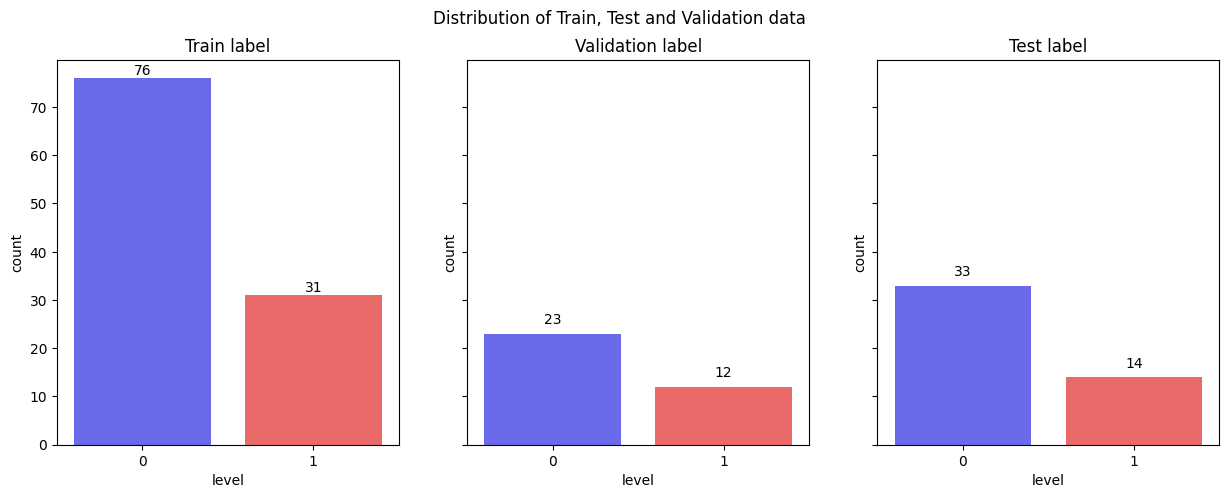

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

ax1 = sns.countplot(x='level', data = train, palette='seismic', ax=axes[0])
axes[0].set_title('Train label')
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

ax2 = sns.countplot(x='level', data = dev, palette='seismic', ax=axes[1])
axes[1].set_title('Validation label')
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax3 =sns.countplot(x='level', data = test, palette='seismic', ax=axes[2])
axes[2].set_title('Test label')
for p in ax3.patches:
    ax3.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.suptitle('Distribution of Train, Test and Validation data')
plt.show()


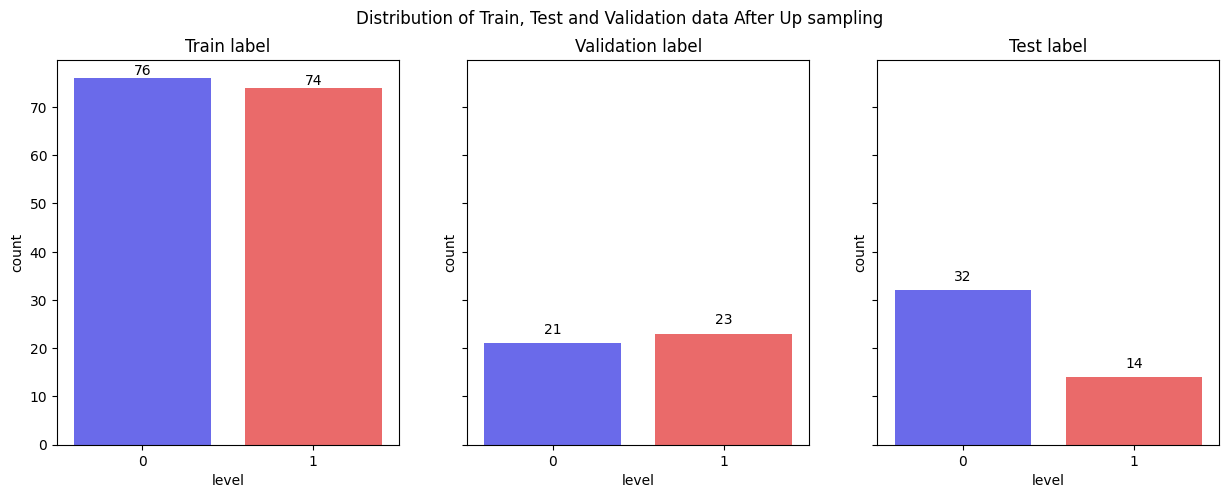

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)


ax1 = sns.countplot(x='level', data = train_df, palette='seismic', ax=axes[0])
axes[0].set_title('Train label')
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

ax2 = sns.countplot(x='level', data = dev_df, palette='seismic', ax=axes[1])
axes[1].set_title('Validation label')
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax3 =sns.countplot(x='level', data = test_lp, palette='seismic', ax=axes[2])
axes[2].set_title('Test label')
for p in ax3.patches:
    ax3.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.suptitle('Distribution of Train, Test and Validation data After Up sampling')
plt.show()


# BERT Model

In [48]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub


In [49]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [50]:
pip install bert-for-tf2

In [51]:
!pip install sentencepiece

In [52]:
from bert import bert_tokenization as tokenization
tokenization.FullTokenizer

bert.tokenization.bert_tokenization.FullTokenizer

In [88]:
def bert_encode(texts, tokenizer, max_len=256):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return  np.asarray(all_tokens).astype(np.float32), np.asarray(all_masks).astype(np.float32), np.asarray(all_segments).astype(np.float32)

In [89]:
from keras.regularizers import l2
def build_model(bert_layer, max_len=256):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(128, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.4)(net)
    net = tf.keras.layers.Dense(64, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    out = tf.keras.layers.Dense(2, activation='softmax')(net)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs = out)
    model.compile(tf.keras.optimizers.Adam(lr = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [90]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/2"
bert_layer = hub.KerasLayer(module_url, trainable= False)

CPU times: user 7.3 s, sys: 1.03 s, total: 8.32 s
Wall time: 13.5 s


In [91]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [92]:
train_input = bert_encode(train_df.answer.values, tokenizer, max_len=128)
dev_input = bert_encode(dev_df.answer.values, tokenizer, max_len=128)
test_input = bert_encode(test_lp.answer.values, tokenizer, max_len=128)

train_labels = train_df.cat_level.values
test_labels=test_lp.cat_level.values
dev_labels=dev_df.cat_level.values

In [93]:
print(train_labels[0])
print(type(train_input))
print(type(train_input[0]))
print(type(train_labels))
print(type(train_labels[0]))

[1.0, 0.0]
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>


In [94]:

train_labels1=[]
for i in train_labels:
  train_labels1.append( np.array(i))

train_labels=np.array(train_labels1)
#print(train_labels)

dev_labels1=[]
for i in dev_labels:
  dev_labels1.append( np.array(i))

dev_labels=np.array(dev_labels1)
#print(dev_labels)

test_labels1=[]
for i in test_labels:
  test_labels1.append( np.array(i))

test_labels=np.array(test_labels1)
#rint(train_labels)



In [95]:
train_input[0].size

19200

In [96]:
'''
print(train_labels)
len(train_labels)

print(dev_labels)
len(dev_labels)

print(test_labels)
len(test_labels)

'''

'\nprint(train_labels)\nlen(train_labels)\n\nprint(dev_labels)\nlen(dev_labels)\n\nprint(test_labels)\nlen(test_labels)\n\n'

In [97]:
'''
y_true  = pd.DataFrame({'y_true': test_labels})
y_true = y_true.to_csv("/content/drive/MyDrive/Final_DLP/y_true.csv" , index=False)
'''

'\ny_true  = pd.DataFrame({\'y_true\': test_labels})\ny_true = y_true.to_csv("/content/drive/MyDrive/Final_DLP/y_true.csv" , index=False)\n'

In [98]:
train_input

(array([[  101.,  4208.,   178., ...,  1105.,  3404.,   102.],
        [  101.,  4208.,   178., ...,  2140.,  1121.,   102.],
        [  101.,  4208., 14863., ..., 14863.,  1139.,   102.],
        ...,
        [  101.,  4208.,   178., ...,  6062.,  1114.,   102.],
        [  101.,  4208.,   178., ..., 12653.,  1194.,   102.],
        [  101.,  2608.,   178., ...,   189.,  1541.,   102.]],
       dtype=float32),
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [99]:
model = build_model(bert_layer, max_len=128)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 segment_ids (InputLayer)    [(None, 128)]                0         []                            
                                                                                                  
 keras_layer_2 (KerasLayer)  [(None, 1024),               3335792   ['input_word_ids[0][0]',

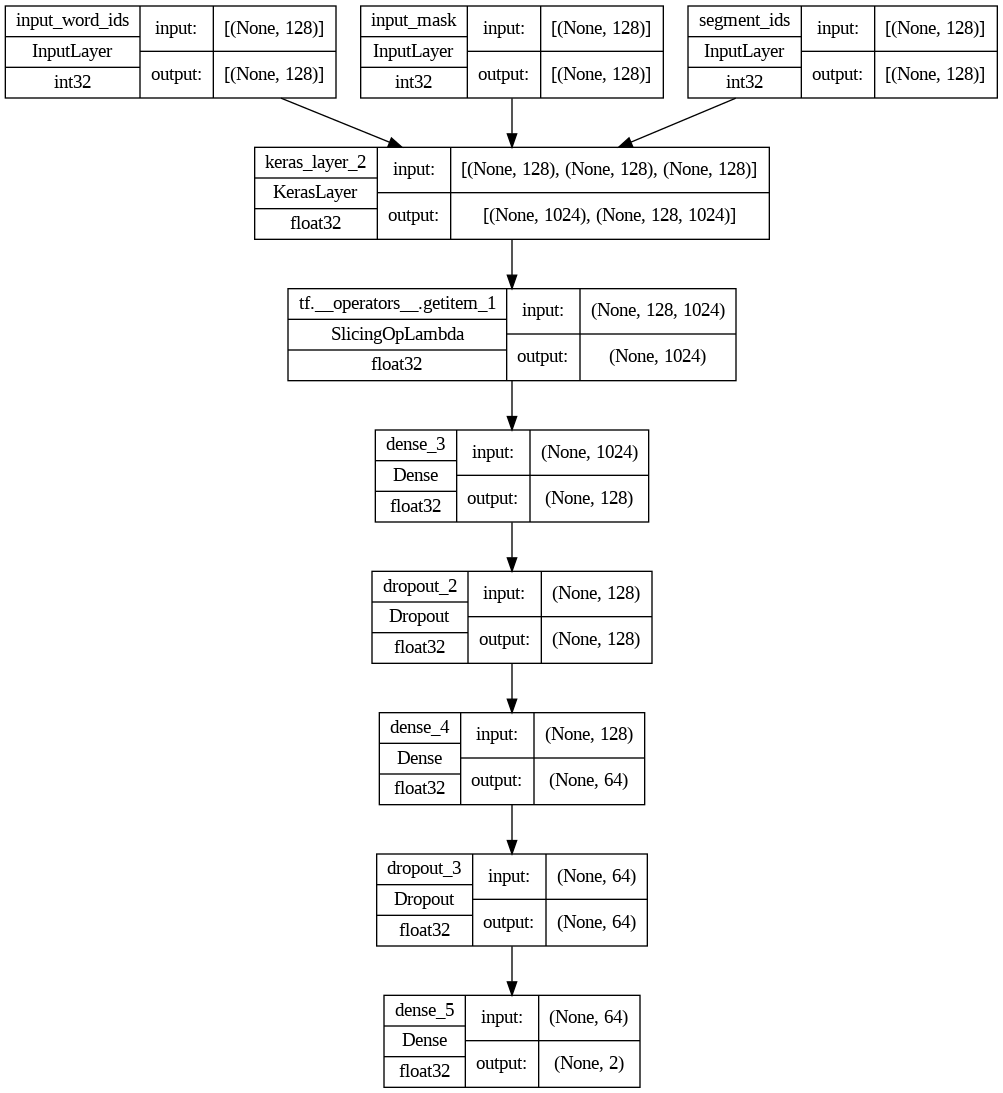

In [100]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [101]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

In [102]:
filepath="/content/drive/MyDrive/Final_DLP/BERT_weights-improvement-{epoch:02d}_valacc{val_accuracy}_valloss{val_loss:.3f}.h5"
early_stop_patience = 5
reduce_lr_patience = 5
earlystopping = EarlyStopping(monitor = 'val_acc',
                              mode = 'max' ,
                              patience = early_stop_patience,
                              verbose = 1)
checkpoint = ModelCheckpoint(filepath,
                             save_weights_only=False,
                             monitor='val_loss',
                             mode='min',
                             verbose=1,
                             save_best_only=True,
                             )
callbacks_list = [earlystopping, checkpoint]

In [103]:
#tain model
train_history = model.fit(
    train_input, train_labels,
    validation_data=(dev_input,dev_labels),
    batch_size=32,
    epochs=20,
    callbacks=callbacks_list

)

model.save('/content/drive/MyDrive/Final_DLP/best_model.h5')

Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 0.8570 - accuracy: 0.5200


Epoch 1: val_loss improved from inf to 0.74268, saving model to /content/drive/MyDrive/Final_DLP/BERT_weights-improvement-01_valacc0.5227272510528564_valloss0.743.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 30s 4s/step - loss: 0.8570 - accuracy: 0.5200 - val_loss: 0.7427 - val_accuracy: 0.5227
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.5867


Epoch 2: val_loss improved from 0.74268 to 0.70408, saving model to /content/drive/MyDrive/Final_DLP/BERT_weights-improvement-02_valacc0.5227272510528564_valloss0.704.h5
5/5 [==============================] - 9s 2s/step - loss: 0.6948 - accuracy: 0.5867 - val_loss: 0.7041 - val_accuracy: 0.5227
Epoch 3/20
5/5 [==============================] - ETA: 0s - loss: 0.7179 - accuracy: 0.5733


Epoch 3: val_loss improved from 0.70408 to 0.66500, saving model to /content/drive/MyDrive/Final_DLP/BERT_weights-improvement-03_valacc0.6590909361839294_valloss0.665.h5
5/5 [==============================] - 11s 3s/step - loss: 0.7179 - accuracy: 0.5733 - val_loss: 0.6650 - val_accuracy: 0.6591
Epoch 4/20
5/5 [==============================] - ETA: 0s - loss: 0.7110 - accuracy: 0.5667


Epoch 4: val_loss improved from 0.66500 to 0.65683, saving model to /content/drive/MyDrive/Final_DLP/BERT_weights-improvement-04_valacc0.6136363744735718_valloss0.657.h5
5/5 [==============================] - 22s 5s/step - loss: 0.7110 - accuracy: 0.5667 - val_loss: 0.6568 - val_accuracy: 0.6136
Epoch 5/20
5/5 [==============================] - ETA: 0s - loss: 0.6770 - accuracy: 0.6333


Epoch 5: val_loss improved from 0.65683 to 0.65300, saving model to /content/drive/MyDrive/Final_DLP/BERT_weights-improvement-05_valacc0.6590909361839294_valloss0.653.h5
5/5 [==============================] - 24s 6s/step - loss: 0.6770 - accuracy: 0.6333 - val_loss: 0.6530 - val_accuracy: 0.6591
Epoch 6/20
5/5 [==============================] - ETA: 0s - loss: 0.6330 - accuracy: 0.6267


Epoch 6: val_loss improved from 0.65300 to 0.64531, saving model to /content/drive/MyDrive/Final_DLP/BERT_weights-improvement-06_valacc0.6818181872367859_valloss0.645.h5
5/5 [==============================] - 13s 3s/step - loss: 0.6330 - accuracy: 0.6267 - val_loss: 0.6453 - val_accuracy: 0.6818
Epoch 7/20
5/5 [==============================] - ETA: 0s - loss: 0.5995 - accuracy: 0.6600


Epoch 7: val_loss improved from 0.64531 to 0.63320, saving model to /content/drive/MyDrive/Final_DLP/BERT_weights-improvement-07_valacc0.6818181872367859_valloss0.633.h5
5/5 [==============================] - 25s 6s/step - loss: 0.5995 - accuracy: 0.6600 - val_loss: 0.6332 - val_accuracy: 0.6818
Epoch 8/20
5/5 [==============================] - ETA: 0s - loss: 0.5629 - accuracy: 0.6867


Epoch 8: val_loss improved from 0.63320 to 0.60976, saving model to /content/drive/MyDrive/Final_DLP/BERT_weights-improvement-08_valacc0.6818181872367859_valloss0.610.h5
5/5 [==============================] - 25s 6s/step - loss: 0.5629 - accuracy: 0.6867 - val_loss: 0.6098 - val_accuracy: 0.6818
Epoch 9/20
5/5 [==============================] - ETA: 0s - loss: 0.5891 - accuracy: 0.6733


Epoch 9: val_loss improved from 0.60976 to 0.60213, saving model to /content/drive/MyDrive/Final_DLP/BERT_weights-improvement-09_valacc0.7045454382896423_valloss0.602.h5
5/5 [==============================] - 21s 5s/step - loss: 0.5891 - accuracy: 0.6733 - val_loss: 0.6021 - val_accuracy: 0.7045
Epoch 10/20
5/5 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.8000


Epoch 10: val_loss did not improve from 0.60213
5/5 [==============================] - 2s 448ms/step - loss: 0.4952 - accuracy: 0.8000 - val_loss: 0.6079 - val_accuracy: 0.7045
Epoch 11/20
5/5 [==============================] - ETA: 0s - loss: 0.5699 - accuracy: 0.7067


Epoch 11: val_loss improved from 0.60213 to 0.57129, saving model to /content/drive/MyDrive/Final_DLP/BERT_weights-improvement-11_valacc0.75_valloss0.571.h5
5/5 [==============================] - 21s 5s/step - loss: 0.5699 - accuracy: 0.7067 - val_loss: 0.5713 - val_accuracy: 0.7500
Epoch 12/20
5/5 [==============================] - ETA: 0s - loss: 0.5534 - accuracy: 0.7000


Epoch 12: val_loss did not improve from 0.57129
5/5 [==============================] - 2s 433ms/step - loss: 0.5534 - accuracy: 0.7000 - val_loss: 0.5732 - val_accuracy: 0.7500
Epoch 13/20
5/5 [==============================] - ETA: 0s - loss: 0.5081 - accuracy: 0.7733


Epoch 13: val_loss did not improve from 0.57129
5/5 [==============================] - 2s 437ms/step - loss: 0.5081 - accuracy: 0.7733 - val_loss: 0.5891 - val_accuracy: 0.7273
Epoch 14/20
5/5 [==============================] - ETA: 0s - loss: 0.5075 - accuracy: 0.7667


Epoch 14: val_loss did not improve from 0.57129
5/5 [==============================] - 2s 380ms/step - loss: 0.5075 - accuracy: 0.7667 - val_loss: 0.5985 - val_accuracy: 0.7273
Epoch 15/20
5/5 [==============================] - ETA: 0s - loss: 0.4444 - accuracy: 0.7733


Epoch 15: val_loss did not improve from 0.57129
5/5 [==============================] - 2s 437ms/step - loss: 0.4444 - accuracy: 0.7733 - val_loss: 0.5864 - val_accuracy: 0.7045
Epoch 16/20
5/5 [==============================] - ETA: 0s - loss: 0.4413 - accuracy: 0.8000


Epoch 16: val_loss improved from 0.57129 to 0.56166, saving model to /content/drive/MyDrive/Final_DLP/BERT_weights-improvement-16_valacc0.7272727489471436_valloss0.562.h5
5/5 [==============================] - 18s 4s/step - loss: 0.4413 - accuracy: 0.8000 - val_loss: 0.5617 - val_accuracy: 0.7273
Epoch 17/20
5/5 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.7733


Epoch 17: val_loss did not improve from 0.56166
5/5 [==============================] - 2s 423ms/step - loss: 0.4671 - accuracy: 0.7733 - val_loss: 0.6149 - val_accuracy: 0.7045
Epoch 18/20
5/5 [==============================] - ETA: 0s - loss: 0.4035 - accuracy: 0.8467


Epoch 18: val_loss improved from 0.56166 to 0.54482, saving model to /content/drive/MyDrive/Final_DLP/BERT_weights-improvement-18_valacc0.75_valloss0.545.h5
5/5 [==============================] - 18s 4s/step - loss: 0.4035 - accuracy: 0.8467 - val_loss: 0.5448 - val_accuracy: 0.7500
Epoch 19/20
5/5 [==============================] - ETA: 0s - loss: 0.3895 - accuracy: 0.7933


Epoch 19: val_loss did not improve from 0.54482
5/5 [==============================] - 2s 379ms/step - loss: 0.3895 - accuracy: 0.7933 - val_loss: 0.6102 - val_accuracy: 0.7045
Epoch 20/20
5/5 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.8133


Epoch 20: val_loss did not improve from 0.54482
5/5 [==============================] - 2s 388ms/step - loss: 0.4290 - accuracy: 0.8133 - val_loss: 0.5906 - val_accuracy: 0.7273


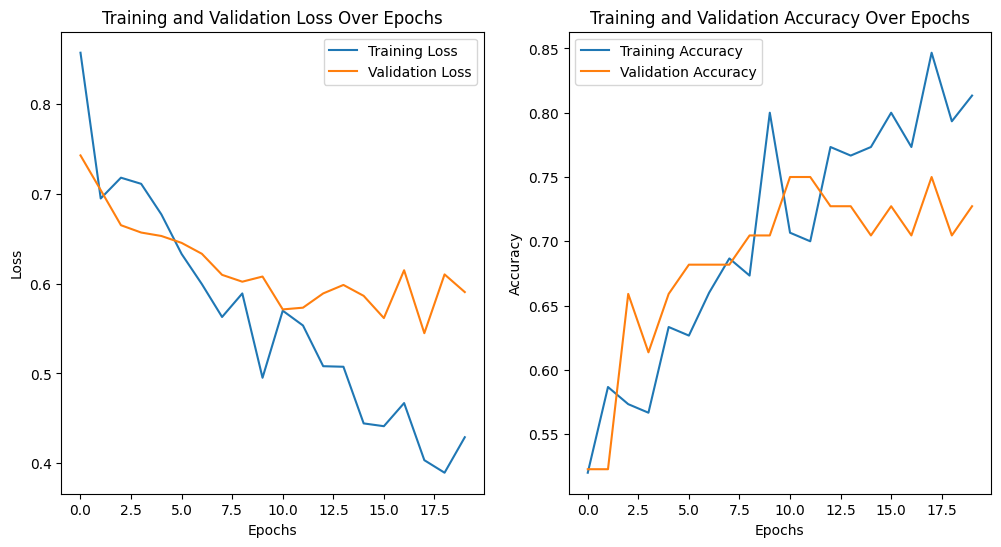

In [104]:

# Retrieve the training and validation loss and accuracy
train_loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
train_acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

# Create a plot for training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Create a plot for training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Display the plots
plt.show()

# Evaluate model

In [105]:
score = model.evaluate(test_input, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:',score[1] )

Test loss: 0.7309562563896179
Test accuracy: 0.695652186870575


In [106]:
%%time
test_pred = model.predict(test_input)

2/2 [==============================] - 2s 229ms/step
CPU times: user 1.67 s, sys: 137 ms, total: 1.8 s
Wall time: 2.17 s


In [107]:
test_pred

array([[0.64752   , 0.35248   ],
       [0.54360217, 0.45639777],
       [0.73083013, 0.26916987],
       [0.8544312 , 0.14556885],
       [0.8293913 , 0.17060868],
       [0.9491926 , 0.05080745],
       [0.91480875, 0.08519123],
       [0.7581583 , 0.24184172],
       [0.8457811 , 0.15421896],
       [0.86520404, 0.13479602],
       [0.4977059 , 0.50229406],
       [0.98223245, 0.01776756],
       [0.37484518, 0.6251548 ],
       [0.8723323 , 0.1276677 ],
       [0.97781265, 0.0221873 ],
       [0.6770012 , 0.32299885],
       [0.8795489 , 0.12045112],
       [0.4866108 , 0.51338917],
       [0.94370085, 0.05629917],
       [0.93224853, 0.0677515 ],
       [0.5543719 , 0.44562814],
       [0.29319954, 0.70680046],
       [0.75173914, 0.24826087],
       [0.49731934, 0.50268066],
       [0.891104  , 0.10889599],
       [0.53051597, 0.46948403],
       [0.89374095, 0.10625909],
       [0.31058577, 0.68941426],
       [0.94400924, 0.05599073],
       [0.73526245, 0.2647375 ],
       [0.

In [108]:
Text_pred = pd.DataFrame(test_pred)
Text_pred.to_csv("/content/drive/MyDrive/Final_DLP/Text_pred.csv", index =False)

In [109]:
y_predict = []
for i in range(len(test_pred)):
  y_pred = np.argmax(test_pred[i])
  y_predict.append(y_pred)

y_test = []
for i in range(len (test_labels)):
  y_label = np.argmax(test_labels[i])
  y_test.append(y_label)

In [110]:
accuracy_score(y_test, y_predict)

0.6956521739130435

In [111]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.74      0.88      0.80        32
           1       0.50      0.29      0.36        14

    accuracy                           0.70        46
   macro avg       0.62      0.58      0.58        46
weighted avg       0.66      0.70      0.67        46



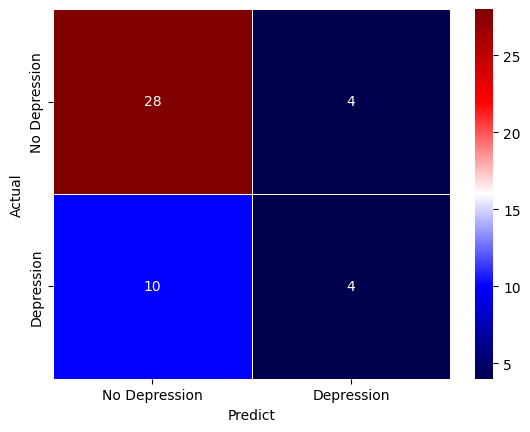

In [112]:
y_true_label = ['No Depression' , 'Depression']
y_pred_label = ['No Depression' , 'Depression']
cm = confusion_matrix(y_test, y_predict)
ax = sns.heatmap(cm, annot = True, cmap = 'seismic',xticklabels = y_pred_label, yticklabels = y_true_label, linewidth=.5, )
ax.set(xlabel='Predict',ylabel='Actual')
plt.show()

In [113]:
from sklearn.metrics import roc_curve
y_pred_roc = model.predict(test_input).ravel()
fprs, tprs, thresholds = roc_curve(y_test, y_predict)

2/2 [==============================] - 0s 224ms/step


In [114]:
from sklearn.metrics import auc
auc_model = auc(fprs, tprs)

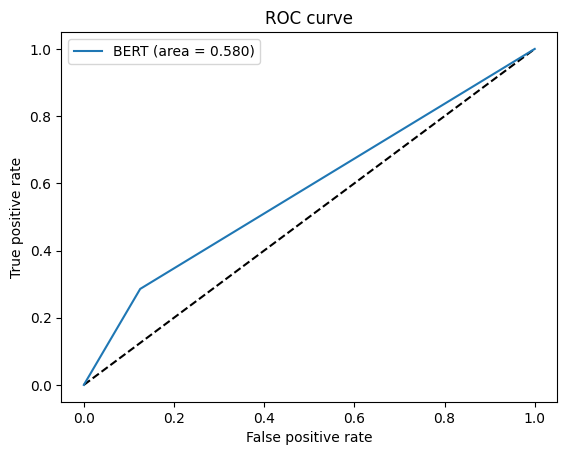

In [115]:
plt.figure(1)
plt.plot([0, 1], 'k--')
plt.plot(fprs, tprs, label='BERT (area = {:.3f})'.format(auc_model))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
